In [231]:
import os
import sys
MAIN_PATH = os.path.dirname(os.getcwd())
sys.path.insert(0, MAIN_PATH)

import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

from utils.utils import add_background_noise

In [232]:
y, sr = librosa.load(
    os.path.join(MAIN_PATH, 'data/The Four Seasons - Spring - Allegro.wav'), sr=8000, duration=30, offset=10
)

In [233]:
noise, _ = librosa.load(os.path.join(MAIN_PATH, 'data/crowd_talking.wav'), sr=8000, duration=30)

In [234]:
z = add_background_noise(y, noise, 0)

In [235]:
S_org = librosa.stft(y=y, n_fft=1024, hop_length=512)
S_noise = librosa.stft(y=z, n_fft=1024, hop_length=512)

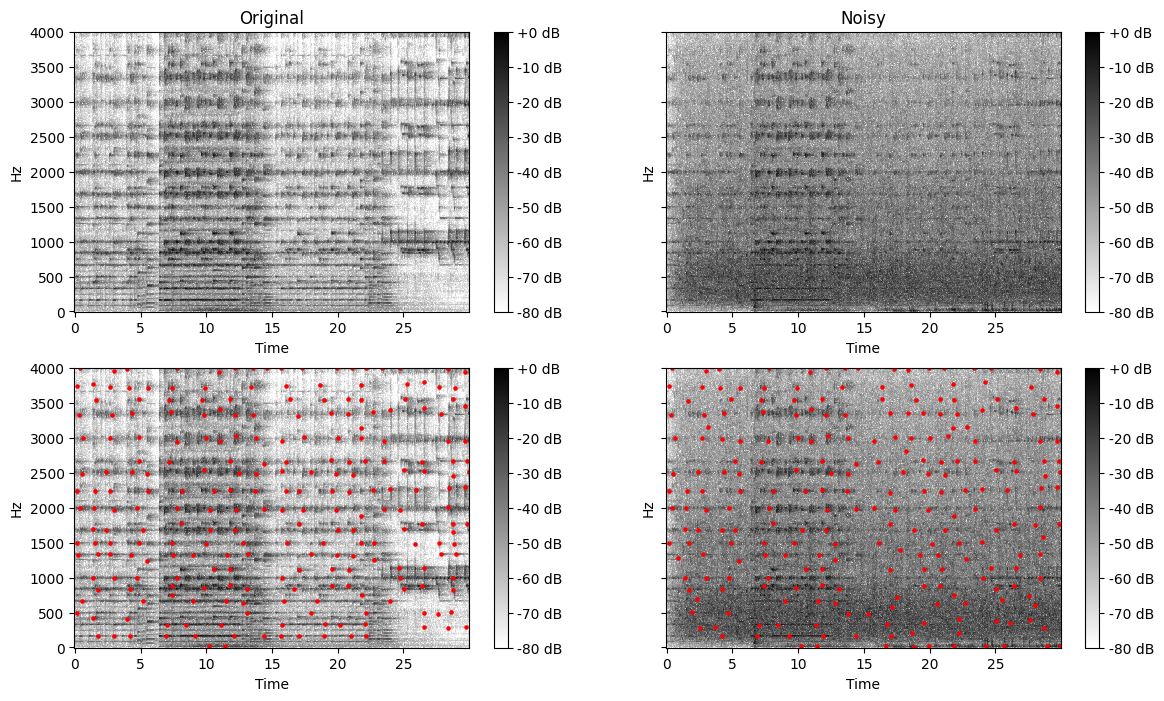

In [236]:
fig, ax = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharey = True)

img_org = librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(S_org), ref=np.max),
    sr=sr,
    hop_length=512,
    n_fft=1024,
    x_axis='time',
    y_axis='linear',
    ax=ax[0, 0],
    cmap='gray_r'
)
ax[0, 0].set_title('Original')

img_noise = librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(S_noise), ref=np.max),
    sr=sr,
    hop_length=512,
    n_fft=1024,
    x_axis='time',
    y_axis='linear',
    ax=ax[0, 1],
    cmap='gray_r'
)

ax[0, 1].set_title('Noisy')

fig.colorbar(img_org, ax=ax[0, 0], format="%+2.f dB")
fig.colorbar(img_noise, ax=ax[0, 1], format="%+2.f dB")

img_org = librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(S_org), ref=np.max),
    sr=sr,
    hop_length=512,
    n_fft=1024,
    x_axis='time',
    y_axis='linear',
    ax=ax[1, 0],
    cmap='gray_r'
)
s = maximum_filter(np.abs(S_org), size=30)
image_max = s == np.abs(S_org)
j, i = np.where(image_max)
t = j * sr / 1024
f = i * 512 / sr

coordinates = np.array(list(zip(f, t)))

ax[1, 0].scatter(
    coordinates[:, 0], coordinates[:, 1], s=5, color='r'
)


img_noise = librosa.display.specshow(
    librosa.amplitude_to_db(np.abs(S_noise), ref=np.max),
    sr=sr,
    hop_length=512,
    n_fft=1024,
    x_axis='time',
    y_axis='linear',
    ax=ax[1, 1],
    cmap='gray_r'
)
s = maximum_filter(np.abs(S_noise), size=30)
image_max = s == np.abs(S_noise)
j_noisy, i_noisy = np.where(image_max)
t_noisy = j_noisy * sr / 1024
f_noisy = i_noisy * 512 / sr

coordinates = np.array(list(zip(f_noisy, t_noisy)))

ax[1, 1].scatter(
    coordinates[:, 0], coordinates[:, 1], s=5, color='r'
)
fig.colorbar(img_org, ax=ax[1, 0], format="%+2.f dB")
fig.colorbar(img_noise, ax=ax[1, 1], format="%+2.f dB")

# plt.savefig(os.path.join(MAIN_PATH, 'images/spectrogram_peaks.pdf'), format='pdf')
plt.show()

In [237]:
def match_query(y_query, y_org):
    S_org = librosa.stft(y=y_org, n_fft=1024, hop_length=512)
    S_noise = librosa.stft(y=y_query, n_fft=1024, hop_length=512)
    s = maximum_filter(np.abs(S_org), size=30)
    image_max = s == np.abs(S_org)
    j, i = np.where(image_max)
    
    org = set([(k, l) for (k, l) in zip(j, i)])
    
    s = maximum_filter(np.abs(S_noise), size=30)
    image_max = s == np.abs(S_noise)
    j, i = np.where(image_max)
    noise = set([(k, l) for (k, l) in zip(j, i)])
    
    return len(noise.intersection(org)) / len(noise)

In [238]:
print(match_query(z, y))

0.6401673640167364


In [239]:
snrs = np.arange(start=-5, stop=15, step=0.5)
scores = []
for snr in snrs:
    scores.append(match_query(add_background_noise(y, noise, snr), y))

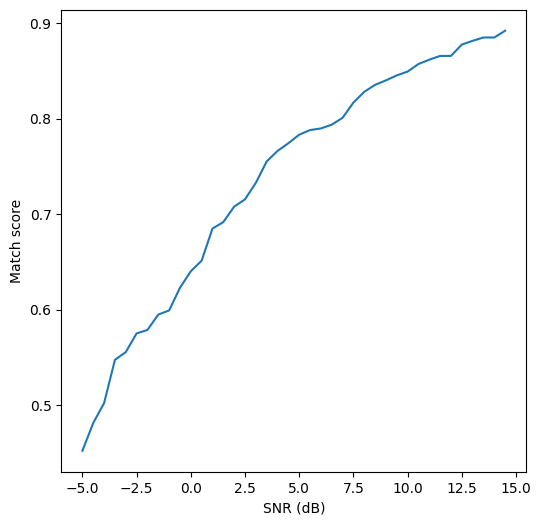

In [240]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(snrs, scores)
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Match score')
# plt.savefig(os.path.join(MAIN_PATH, 'images/match_score_vs_snr.pdf'), format='pdf')
plt.show()